#### CIE4604 - Simulation and Visualisation

# Assignment 3 - Time Series Analysis of Vegetation Index

<br>

**Student Name(s):** Maxwell Lindsay

**Student Number(s):** 5243610

In this assignment we do a time series analysis of NDVI using the HANTS (Harmonic Analysis of Time Series) algorithm and visualize the results in Python and QGIS. 

For a description of the assignment consult the `CIE4604-A3-NDVI_HANTS.pdf` document.


# Part I - Compute and Visualize NDVI in QGIS 

<div class="alert alert-block alert-info">
If you prefer, you may add the QGIS results of part I here. See CIE4604-A3-NDVI_HANTS.pdf a detailed description of the actions.
</div>

In your report (or here) include at least the following results: 

- Part I.a
  - Layout with the two NDVI maps, side by side, using the same map scale, with titles, legend and scale bar. You have to choose an appropriate representation (colormap) for the NDVI data (your grade depends on this)

  ![nice](part1a.jpeg)
  
  - A brief explanation on the method you used to extracted the data for the area of interest, with answers to the questions
  - Your motivation for the chosen representation (colormap) for the NDVI data

- Part I.b
  -	Layout with the categorized training dataset.

  
  -	Screenshot of the excel file with the attribute table 

Furthermore, include in the zip file accompanying the report,
-	The excel file with attributes (including zonal statistics)
-	The re-projected training dataset (you will also need this for Part II)



# Part II - NDVI time series analysis with HANTS

HANTS is a software using the Fourier Analysis in order to detect outliers (clouds) and reconstruct image time series.  
The analysis is performed over Sector BXII, an agricultural area located close to Sevilla (Spain). 
Input data files for this script are:

* `NDVI_BXII_time_series_2017_2018_S2A_SP.tif`  (Geotiff with NDVI time series)
* `NDVI_BXII_time_series_images_list.csv`  (Csv-file with the date, day number and day of year for the images)

Optional (non-required) input file(s) are:

* ` Training_2017_UTM30N_WGS84_SP.shp`   (Training dataset)

The actual HANTS algorithm is implemented in the Python function `hants.py`, see also `help(hants.py)`. 

<div class="alert alert-block alert-info">
This script is a template that you have to modify in places to obtain the desired results. Enter your answers as markdown.
</div>


In [1]:
# Importing all the libraries required for this assignment
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar as colorbar
import matplotlib.colors as colors
import matplotlib.animation as animation
import matplotlib as mpl
import pandas as pd
import rasterio
import shapefile
import cmocean

from scipy.io import loadmat
from datetime import date, datetime
from hants import hants

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10, 10)


### Load NDVI for Sector BXII, Sevilla, Spain

The input files are:

* `NDVI_BXII_time_series_2017_2018_S2A_SP.tif - geotiff with NDVI` 
* `NDVI_BXII_time_series_images_list.csv`  (Csv-file with the date, day number and day of year for the images)

The code for reading these dataset was already developed in Exercise 4. The following variables are created

* NDVI - 3-D array with dimensions [time, lat, lon] , i.e. NDVI[k,:,:] contains the k'th NDVI image at time ts[k] 
* ts, tsdoy, tsdatestring - 1-D arrays with respectively number of days since 12/04/2017 (ts), day of year (tsdoy) and datestrings (tsdatestring).

You should definitely take a look at each variable to see what it is about.

In [2]:
# set the filenames and filepath
path = "./cie4604_a3_hants/Hants/"
NDVIfile = "NDVI_BXII_time_series_2017_2018_S2A_SP.tif"
Datefile = "NDVI_BXII_time_series_images_list.csv"


In [3]:
# open GeoTIFF dataset as an object
src = rasterio.open(path + NDVIfile)

# print meta data (selection)
for key, value in src.meta.items():
    print(key, ": ", value)

print("\nbounds", src.bounds)
print("wkt", src.crs.wkt)

# compute imshow extent
extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print("extent", extent)

# Read the image data
NDVI = src.read()
print("\nNDVI shape", NDVI.shape)


driver :  GTiff
dtype :  float64
nodata :  None
width :  866
height :  800
count :  33
crs :  EPSG:32630
transform :  | 20.00, 0.00, 214920.00|
| 0.00,-20.00, 4106200.00|
| 0.00, 0.00, 1.00|

bounds BoundingBox(left=214920.0, bottom=4090200.0, right=232240.0, top=4106200.0)
wkt PROJCS["WGS_1984_UTM_Zone_30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
extent [214920.0, 232240.0, 4090200.0, 4106200.0]

NDVI shape (33, 800, 866)


In [4]:
# Read dates using Panda
datetable = pd.read_csv(path + Datefile)

# Preview the first 5 lines of the loaded dates
datetable.head()


,Band,ISOdate,Day,Doy
0,1,2017-04-12,1,102
1,2,2017-04-22,11,112
2,3,2017-05-02,21,122
3,4,2017-05-12,31,132
4,5,2017-05-22,41,142


In [5]:
# Preview the data types
print(datetable.dtypes)


Band        int64
ISOdate    object
Day         int64
Doy         int64
dtype: object


In [6]:
# Convert to 1-D numpy arrays
ts = np.array(datetable.Day)
tsdatestrings = np.array(datetable.ISOdate)
tsdoy = np.array(datetable.Doy)
print("ts", ts)
print("tsdatestrings", tsdatestrings)
print("tsdoy", tsdoy)


ts [  1  11  21  31  41  51  61  71  81  91 101 111 131 141 151 161 171 181
 191 201 211 221 231 241 261 271 291 301 311 321 341 351 371]
tsdatestrings [' 2017-04-12' ' 2017-04-22' ' 2017-05-02' ' 2017-05-12' ' 2017-05-22'
 ' 2017-06-01' ' 2017-06-11' ' 2017-06-21' ' 2017-07-01' ' 2017-07-11'
 ' 2017-07-21' ' 2017-07-31' ' 2017-08-20' ' 2017-08-30' ' 2017-09-09'
 ' 2017-09-19' ' 2017-09-29' ' 2017-10-09' ' 2017-10-19' ' 2017-10-29'
 ' 2017-11-08' ' 2017-11-18' ' 2017-11-28' ' 2017-12-08' ' 2017-12-28'
 ' 2018-01-07' ' 2018-01-27' ' 2018-02-06' ' 2018-02-16' ' 2018-02-26'
 ' 2018-03-18' ' 2018-03-28' ' 2018-04-17']
tsdoy [102 112 122 132 142 152 162 172 182 192 202 212 232 242 252 262 272 282
 292 302 312 322 332 342 362   7  27  37  47  57  77  87 107]


## Colormap selection

To plot the NDVI for the first day we are going to use matplotlib's `imshow` method to make a pseudo-color map. A good colormap for the NDVI is essential! It is up to you to come up with a good colormap for the NDVI, taking into account the lessons learned from Exercise 1 and 2. You may also use your answer from Exercise 4 here (this is a repetition). 

Start by formulating the requirements for the color map. What kind of color map should we select? What is the range? Do we use a linear map, is it continuous or discrete, do we use two tones?  What kind of normalization are we going to use?
In any case, the default color map is certainly not a good choice. Why?

Have a look for instance at the following [article](https://publiclab.org/notes/cfastie/08-26-2014/new-ndvi-colormap) to get some inspiration.

<div class="alert alert-block alert-info">
Explain here your considerations for the colormap and the reasons for choice in markdown
</div>


In the section below set the `cmap` variable with the chosen colormap.

In Python you can read the text file or `mat` file and create the colormap using `matplotlib.colors.ListedColormap`. See also Exercise 1 and 2.
```python
cmapTable = scipy.io.loadmat('file.mat')['colors']
cmap = colors.ListedColormap(data/255)
```
You can then declare this new colormap in the `imshow` function by declaring the input as `cmap = cmap`

In [7]:
# SELECT APPROPRIATE COLORMAP FOR NDVI
cmap = (
    cmocean.cm.delta
)  # default colormap for matplotlib, change this for something better!!
# END COLORMAP SELECTION
clim = [-1, 1]  # NDVI range


## Pseudo color image plot of unfiltered NDVI for the first day

To plot the NDVI for the first day we are going to use matplotlib's `imshow` method to make a pseudo-color map. 
Use the colormap that you selected above using the `cmap = cmap` optional parameter in `imshow`, together with 'clim' and 'extent'.

The optional `extent` parameter is used to set the proper x- and y-axis coordinates. It is computed from the image bounds, while converting meter units to km.

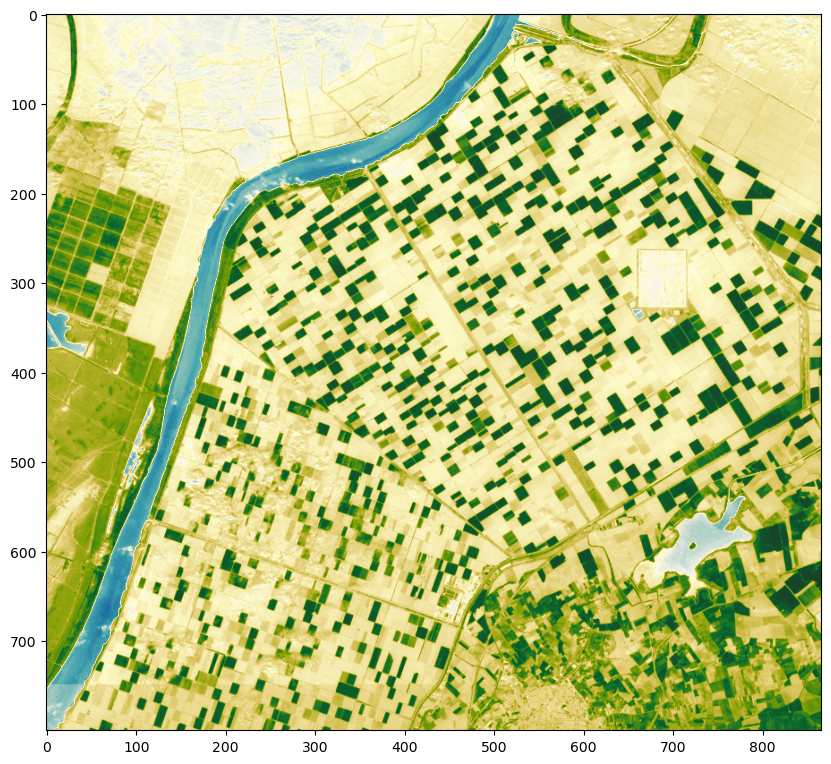

In [8]:
# Put your code here ((you may borrow it from Exercise 4)
plt.imshow(NDVI[1], cmap=cmap, clim=clim)



## Create a video with the unfiltered NDVI data

A video is created showing the (unfiltered) NDVI data. We use `imshow` to  display matrix NDVI(i,:,:) as an image for day *i*, using the colormap of your choice (see previous section).

The figure statement is called only once, imshow is called from within the loop over days, and the output is appended to the list of frames.

There are two ways to display the animation from a notebook,

- show the animation in a separate window using qt
- show the animation inline usign html5

You can also save the animation as either a mpeg file or an animated gif (both are commented out at the moment). The code is borrowed from Exercise 4.

In [9]:
plt.rc('animation', html='jshtml')

C:\Users\maxli\anaconda3\envs\BPD4a\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


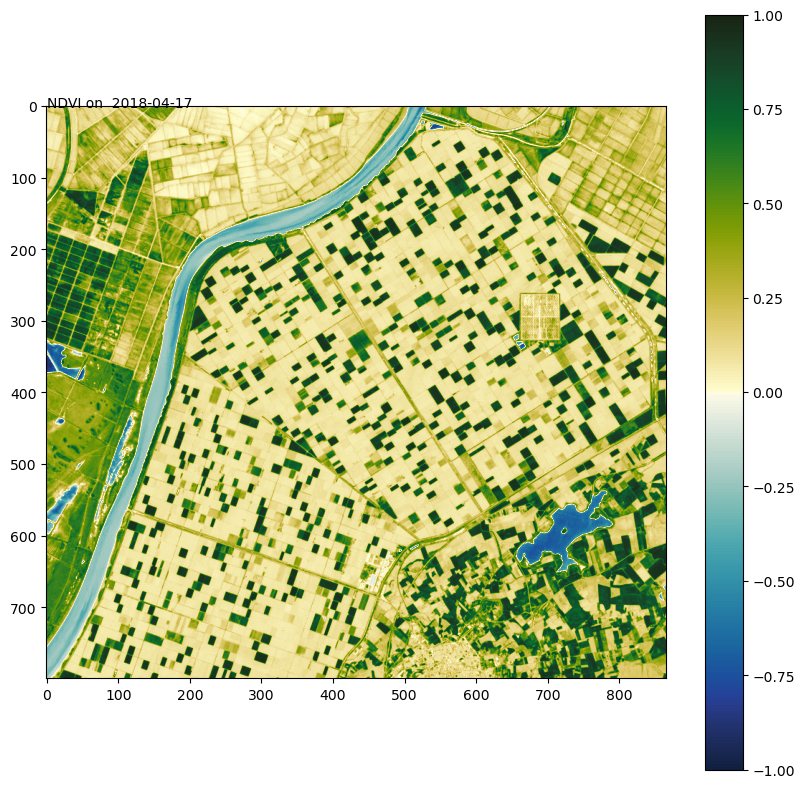

In [11]:
# Put your code here, you may borrow it from Exercise 4
fig, ax = plt.subplots()
ndates = NDVI.shape[0]

# create a function to return a list of image and title
def mapday(daynum):
    date_ = tsdatestrings[daynum]
    local_ax = ax.imshow(
        NDVI[daynum, :, :], cmap=cmap, clim=clim, animated=True, aspect="equal"
    )
    title = plt.text(0.5, 1.05, f"NDVI on {date_}")
    return [local_ax, title]


# use list comprehension to make frames
frames = [mapday(i) for i in range(1, ndates)]

# generate animation object
anim = animation.ArtistAnimation(
    fig, frames, interval=300, blit=False, repeat_delay=500
)

# save resultsF
fig.colorbar(frames[0][0], ax=ax)
anim.save("NDVI_anim.mp4")


## Compute reconstructed time series using HANTS

Inputs for HANTS are the times ts (days) and the NDVI time series for one pixel. For the other input parameters see the help that comes with HANTS.

In [ ]:
help(hants)


Based on the help information define your HANTS input parameters below. Some are preset, others are left open.

In [ ]:
# length of the base period (usually one year) measured in timeunits of ts (number of days)
nb =
# number of frequencies to be considered above the zero frequency ( 1 ... 6)
nf =
# fit error tolerance (points deviating more than fet from curve fit are rejected, 0.05 ... 0.3)
fet =
# 2-character string indicating rejection of high or low outliers ('Lo' or 'Hi')
HiLo = 'Lo'
low = -1        # valid range minimum (values below are rejected right away)
high = +1       # valid range maximum (values above are rejected right away)
# degree of overdeterminedness (iteration stops if number of points reaches the minimum required)
dod = 1
delta = 0.1     # small positive number (e.g. 0.1) to suppress high amplitudes


Set the line and sample number of the pixel for which to apply HANTS.

We will show you later how to find the line and sample numbers for specific pixel areas, e.g. one of the field in the training set.

In [ ]:
row = 348
col = 299


Do HANTS, first we have to extract the pixel data into the array datain. We use the Matlab function squeeze to do this, because NDVI is stored as a three dimensional array and we have to collect all values that belong to a single pixel. We use squeeze because NDVI[:,row,col] does not return an array, but a list, and squeeze will convert this list to an array.

HANTS Outputs are:

      amp   = array of amplitudes, first element is the average of the curve
      phi   = array of phases, first element is zero
      dataout	= array holding reconstructed time series 
      outliers	= boolean array with the outliers 


In [ ]:
ndates = NDVI.shape[0]
datain = np.squeeze(NDVI[:, row, col])

amp, phi, dataout, outliers = hants(
    ndates, nb, nf, datain, ts, HiLo, low, high, fet, dod, delta)

print('amp', amp)
print('phi', phi)
print('dataout', dataout)
print('outliers', outliers)
numoutliers = np.sum(outliers)
print('numoutliers', numoutliers)


### Plot the original vs reconstructed time series

In [ ]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(ts, datain, 'b*', label='Original NDVI')
plt.plot(ts[outliers], datain[outliers], 'rx', markersize=10,
         markeredgewidth=3, label='Outlier NDVI')
plt.plot(ts, dataout, 'r', label='Smoothed with HANTS')
plt.xlim([1, 365])
#plt.ylim([0, 1])
plt.xlabel('Days from 12 April 2017')
plt.ylabel('NDVI [-]')
plt.title('NDVI - Sentinel 2 (row {}, column {})'.format(row, col))
plt.text(6, 0.77, 'nb={}\nnf={}\nfet={}\noutliers={}'.format(
    nb, nf, fet, numoutliers))
plt.legend()
plt.show()


## Select suitable HANTS input parameters

Use the above code as a template to select a suitable set of input parameters. 
You can try different values for the number of frequencies (nf) ,  base period (nb) and fit error tolerance.  

You should at least

- Plot the reconstructed vs the original  time series for two vegetated pixels characterized by different temporal trend (different crop growing cycles).
- Plot the reconstructed vs the original  time series for different HANTS input parameters, but **ONLY GIVE RESULTS FOR A FEW SENSIBLE SELECTIONS** to underline your choice for the **frequency** and/or **error tolerance**.

In the report, explain your choice for the base period (you don't have to show plots, there is only one good value for the base period), and include the plots for the chosen parameters. 

In [ ]:
# Add your plots here


*[Add your explanation here]*

## Apply HANTS for all pixels

Apply the HANTS algorithm for all pixels, and save the amplitude, phase and reconstucted NDVI.
<div class="alert alert-block alert-danger">
<b>THIS IS A VERY TIME CONSUMING PROCESS THAT MAY TAKE 15-30 MINUTES! SO ONLY DO THIS WHEN YOUR ARE SURE YOU GOT THE CORRECT PARAMETERS, OR TEST IT FIRST ON A SMALLER SAMPLE. </b>
</div>


In [ ]:
print('Smoothing and filling the missing data, please be patient ... ')

# Initialize new arrays to collect the HANTS output
ni, ny, nx = NDVI.shape
NDVI_HANTS = np.zeros((ni, ny, nx))
amp = np.zeros((nf + 1, ny, nx))
phi = np.zeros((nf + 1, ny, nx))

# Call HANTS in a double loop, line by line (SEE THE WARNING)
# for row in range(0, 10): # use this for smaller sample
for row in range(0, ny):
    if (row % 25) == 0:
        print("Doing line {} out of {}".format(row, ny))
    for col in range(0, nx):
        data = NDVI[:, row, col]
        if np.isnan(data).sum() != ni:
            data[np.isnan(data)] = low - 1.0
            amp_, phi_, yr_, outlier_ = hants(
                ndates, nb, nf, data, ts, HiLo, low, high, fet, dod, delta)
            amp[:, row, col], phi[:, row, col], NDVI_HANTS[:,
                                                           row, col] = amp_, phi_, yr_

print("Done with smoothing and filling")


## Save the results now!!

<div class='alert alert-info'>
Variables can be saved and loaded with the Spyder IDE. Do that for the newly computed results, so that for the follow on work you don't have to redo the time consuming processing every time. Here we will make use of pickle library to store the variables so that we can always reload them later.
</div>

In [ ]:
# Save important variables
import pickle

f = open('NDVIr.pckl', 'wb')
pickle.dump([ts, tsdatestrings, extent, NDVI_HANTS, amp, phi], f)
f.close()


If the variables have to be reloaded you can use the following code.

In [ ]:
# ReLoad the variables
# f = open('NDVIr.pckl', 'rb')
# ts, tsdatestrings, extent, NDVI_HANTS, amp, phi = pickle.load(f)
# f.close()


## Write GeoTIFF files with reconstructed NDVI, amplitude and phase

Three new GeoTIFF files are created, with

- the reconstructed (smoothed) NDVI
- the amplitude
- the phase

These files can easily be imported by other software such as QGIS.

In [ ]:
# Save reconstructed NDVI as GeoTiff file
profile = src.profile
with rasterio.open('NDVI_reconstructed.tif', 'w', **profile) as dst:
    for id, layer in enumerate(NDVI_HANTS, 1):
        dst.write_band(id, NDVI_HANTS[id - 1, :, :])

# Save Amplitude as GeoTiff file
profile = src.profile
profile['count'] = len(amp)
with rasterio.open('NDVI_amplitude.tif', 'w', **profile) as dst:
    for id, layer in enumerate(amp, 1):
        dst.write_band(id, amp[id - 1, :, :])

# Save Phase as GeoTiff file
profile = src.profile
profile['count'] = len(phi)
with rasterio.open('NDVI_phase.tif', 'w', **profile) as dst:
    for id, layer in enumerate(phi, 1):
        dst.write_band(id, phi[id - 1, :, :])


## Create a video of the reconstruced NDVI data

Create a video showing the reconstructed NDVI data.

In [ ]:
# Your code here


Instead of an animation we can also create a lot of subplots using the code below.

In [ ]:
%matplotlib inline
ndates = NDVI_HANTS.shape[0]

ncols = 5
nrows = int(np.ceil(ndates/ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(21, 27), tight_layout=True)
axs = axs.flat
[axi.set_axis_off() for axi in axs]

for i in range(ndates):
    titlestr = 'Reconstructed NDVI ' + \
        tsdatestrings[i] + ' DAY ' + str(int(ts[i]))
    axs[i].imshow(NDVI_HANTS[i, :, :], extent=extent,
                  aspect='equal', cmap=cmap, clim=clim)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(titlestr)

plt.show()


## Plot amplitude and phase from HANTS

Make a figure with in the subplots a pseudo color image of the amplitude and phase for each frequency. Please think carefully about the colormap to use.

Which colormap do you use for the amplitude. Should the colormap for the phase be the same, or different. Please explain why.


In [ ]:
# Your code here


## Analyze the training dataset
The training dataset is a shapefile with information on the actual crop that is growing in the fields. The original training dataset was in UTM zone 29N. We used QGIS to convert this to UTM zone 30N, which was is also the zone that is used for the NDVI data.

First we must read the shape file with training data
```python
training = shapefile.Reader("Training_set/Training_2017_UTM30N_WGS84_SP.shp")
```

In [ ]:
# Your code here


The training dataset consists of 15 polygons. We will create an plot with the amplitude data and overlay the polygon boundaries.

In [ ]:
plt.figure(figsize=(12, 8))
for shape in training.shapeRecords():
    x = [i[0]/1000 for i in shape.shape.points[:]]
    y = [i[1]/1000 for i in shape.shape.points[:]]
    plt.plot(x, y, color='yellow', linewidth=2)
greys = mpl.cm.get_cmap('Greys_r')
plt.imshow(amp[1, :, :], extent=extent, cmap=greys)
plt.axis('image')
plt.colorbar(label='Amplitude [-]')
plt.ylabel('North [km]')
plt.xlabel('East [km]')
plt.title('NDVI Training set')
plt.show()
plt.show()


# Part III -  Visualize HANTS output in QGIS  

<div class="alert alert-block alert-info">
If you prefer, you may add the QGIS results of part III here.  See CIE4604-A3-NDVI_HANTS.pdf a detailed description of the actions.
</div>

[End of the assignment]